[<< Data Preparation](01_initial_data_prep.ipynb) &nbsp; | &nbsp; [Model Fitting >>](03_rating_pred.ipynb)

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
df <- read_csv("../data/pitchfork/meta_df_dbr.csv")

Rows: 22063 Columns: 8
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): artist, album, reviewer, genre, label, reviewed
dbl (2): rating, review_n_tokens

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
df %>% head()

artist,album,rating,reviewer,genre,label,reviewed,review_n_tokens
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
Joni Mitchell,Joni Mitchell at Newport,6.0,Grayson Haver Currin,Rock,Rhino,"July 29, 2023",802
The Clientele,I Am Not There Anymore,8.0,Marc Hogan,Rock,Merge,"July 28, 2023",803
Nas,Magic 2,6.5,Dylan Green,Rap,Mass Appeal,"July 28, 2023",799
Beverly Glenn-Copeland,The Ones Ahead,8.0,Jesse Dorris,Experimental,Transgressive,"July 28, 2023",790
Damon Locks,New Future City Radio,6.9,Matthew Blackwell,Jazz / Experimental,International Anthem,"July 28, 2023",873
DJ K,PANICO NO SUBMUNDO,7.9,Nadine Smith,Experimental,Nyege Nyege Tapes,"July 27, 2023",761


In [4]:
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 100)

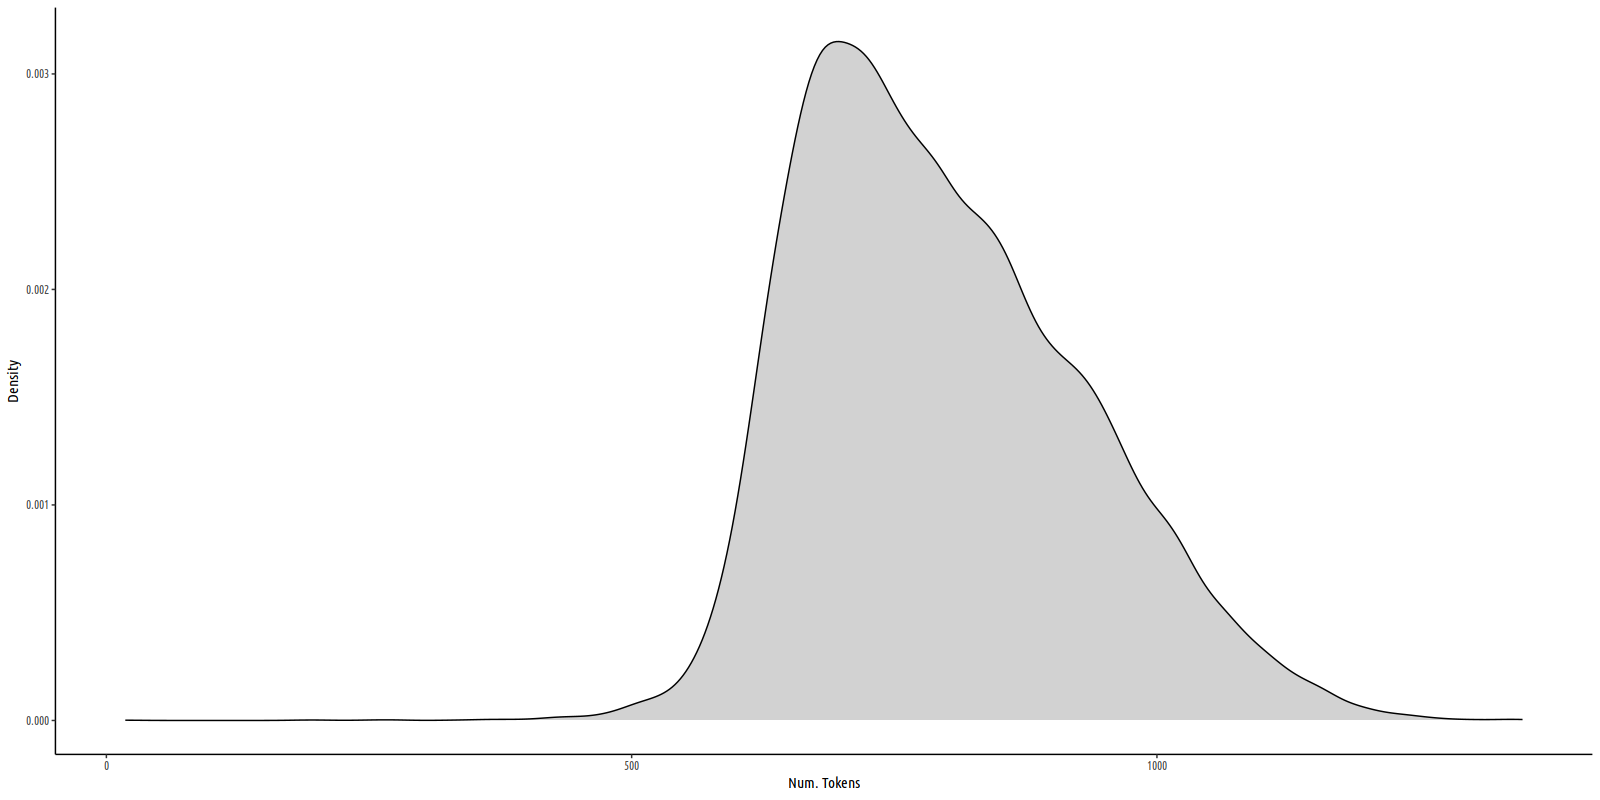

In [5]:
df %>%
    ggplot() +
    # geom_histogram(aes(review_n_tokens), binwidth=25, alpha=0.7) +
    geom_density(aes(review_n_tokens), alpha=0.7, fill="gray") +
    theme_classic() +
    xlab("Num. Tokens") +
    ylab("Density")

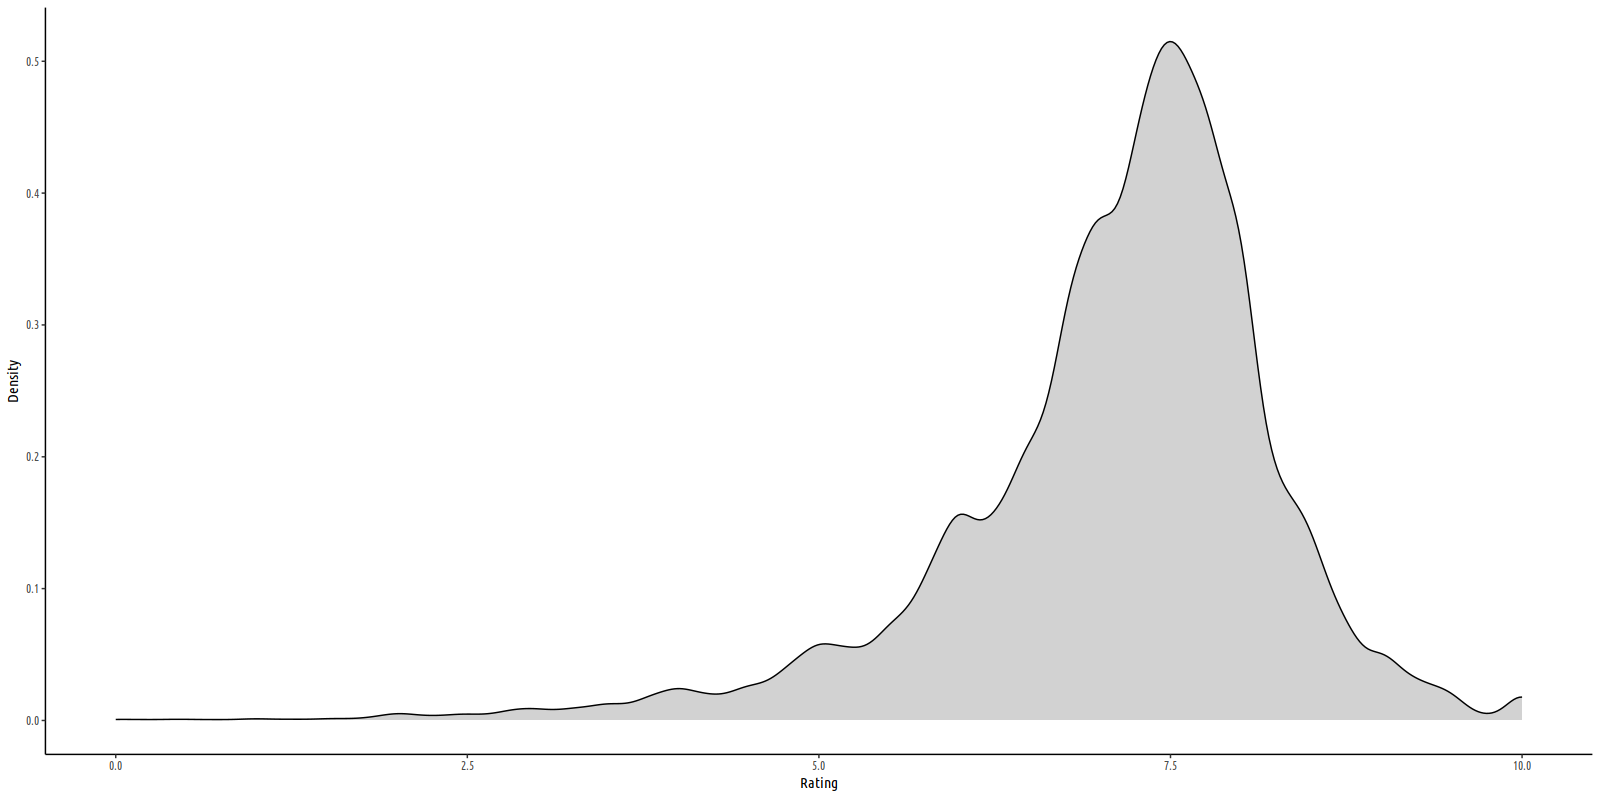

In [6]:
df %>%
    ggplot() +
    # geom_histogram(aes(rating), binwidth=0.2, alpha=0.7) +
    geom_density(aes(rating), alpha=0.7, fill="gray") +
    theme_classic() +
    xlab("Rating") +
    ylab("Density")

In [7]:
df %>%
    distinct(artist) %>%
    nrow()

[1] 10242

In [8]:
df %>%
    nrow()

[1] 22063

In [9]:
df %>%
    distinct(artist, album) %>%
    nrow()

[1] 22053

In [10]:
df %>%
    add_count(album, artist, rating, reviewed) %>%
    filter(n > 1) %>%
    arrange(n, album, artist)

artist,album,rating,reviewer,genre,label,reviewed,review_n_tokens,n
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>


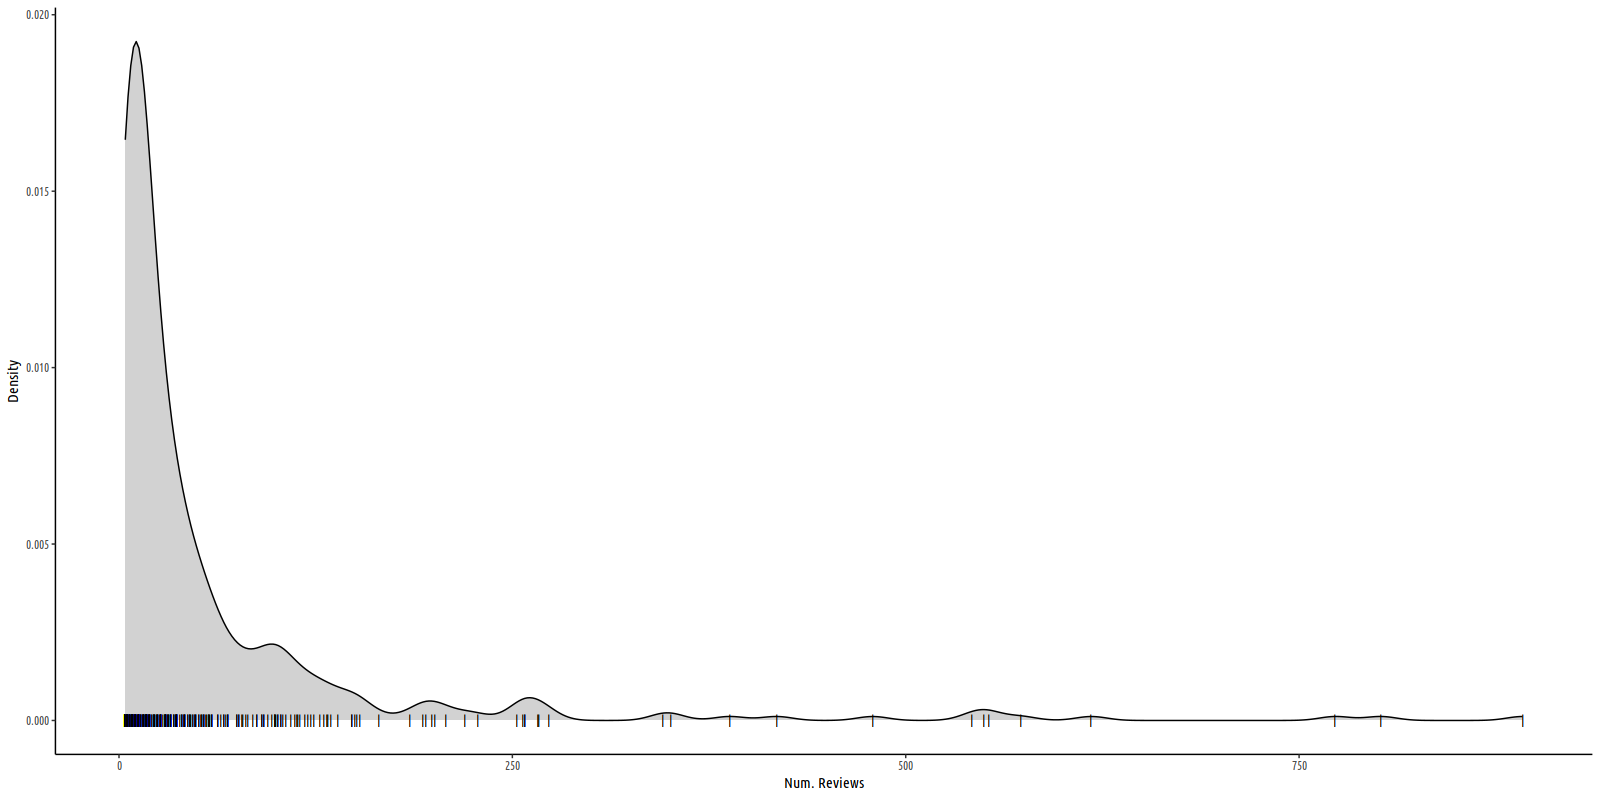

In [11]:
df %>%
    count(reviewer, name="n_reviews") %>%
    # group_by(reviewer) %>%
    # summarize(mean_rating = mean(rating), n_ratings = n()) %>%
    filter(n_reviews > 3) %>%
    ggplot() +
    geom_density(aes(n_reviews), alpha=0.7, fill="gray") +
    geom_point(aes(x=n_reviews, y=0), shape="|", size=3) +
    theme_classic() +
    xlab("Num. Reviews") +
    ylab("Density")

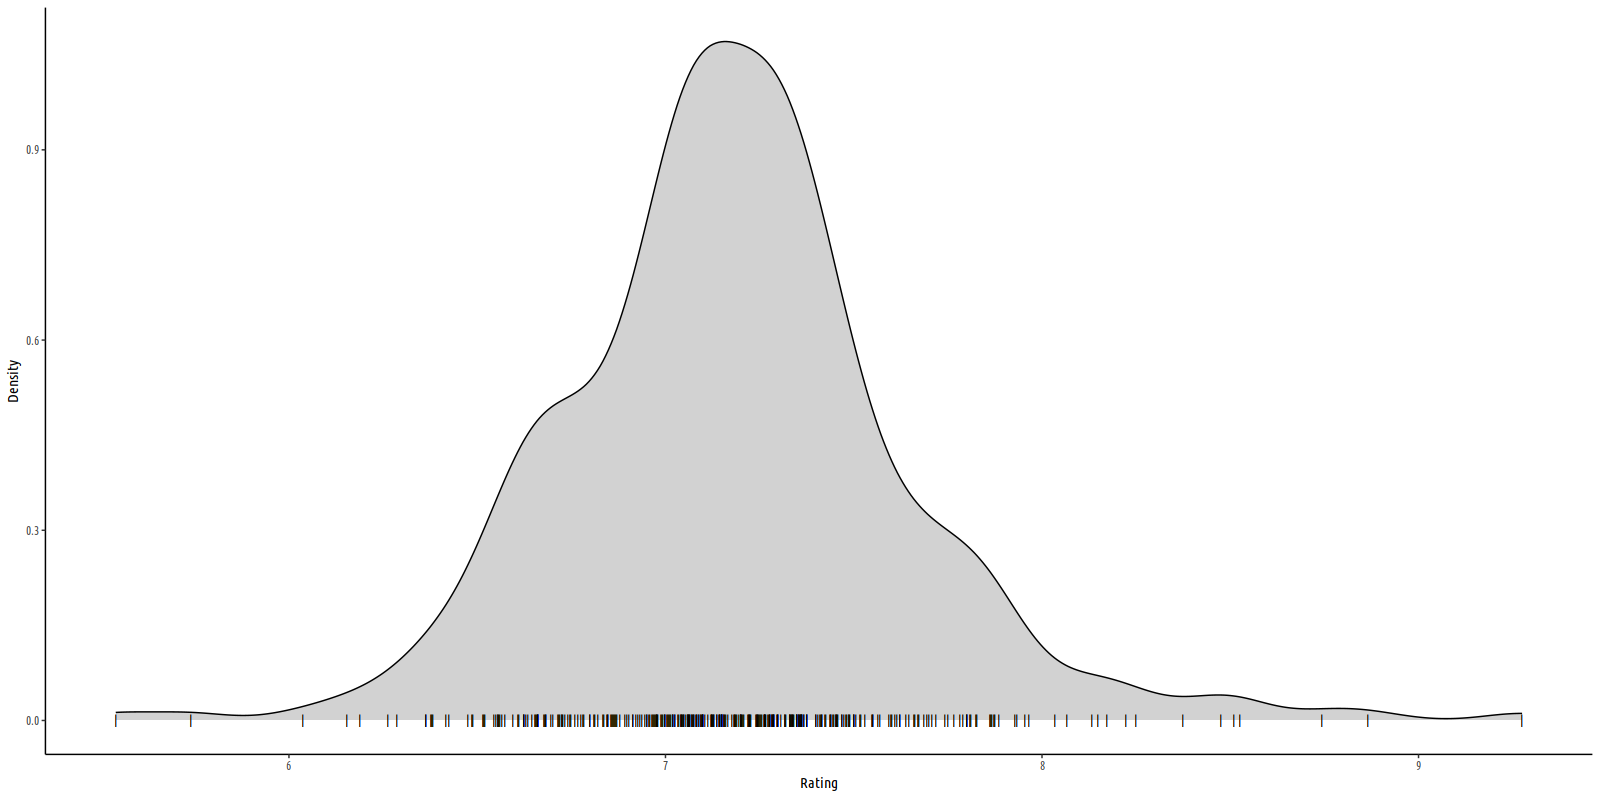

In [12]:
df %>%
    group_by(reviewer) %>%
    summarize(mean_rating = mean(rating), n_ratings = n()) %>%
    filter(n_ratings > 3) %>%
    ggplot() +
    geom_density(aes(mean_rating), alpha=0.7, fill="gray") +
    geom_point(aes(x=mean_rating, y=0), shape="|", size=3) +
    theme_classic() +
    xlab("Rating") +
    ylab("Density")

In [13]:
harshness_df <- df %>%
    group_by(reviewer) %>%
    summarize(mean_rating = mean(rating), n_ratings = n()) %>%
    filter(n_ratings > 3) %>%
    arrange(mean_rating) %>%
    mutate(harshness = 1:n())

In [14]:
df %>%
    filter(reviewer == "Brad Shoup") %>%
    arrange(rating)

artist,album,rating,reviewer,genre,label,reviewed,review_n_tokens
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
Foster the People,Sacred Hearts Club,5.5,Brad Shoup,Electronic / Rock,Columbia,"July 24, 2017",802
Gang of Four,Complicit EP,5.7,Brad Shoup,Rock,GO4 Music,"April 25, 2018",717
The Smashing Pumpkins,ATUM,6.3,Brad Shoup,Rock,Martha’s Music,"May 11, 2023",617
Galantis,The Aviary,6.4,Brad Shoup,Electronic,Atlantic,"September 16, 2017",816
The National,First Two Pages of Frankenstein,6.6,Brad Shoup,Rock,4AD,"April 27, 2023",759
DC Talk,Jesus Freak,6.7,Brad Shoup,Rock,ForeFront,"August 1, 2021",713
Okkervil River,In the Rainbow Rain,6.9,Brad Shoup,Rock,ATO,"May 16, 2018",675
Linda Perhacs,I'm a Harmony,7.0,Brad Shoup,Folk/Country,Omnivore,"September 22, 2017",1003
12 Rods,If We Stayed Alive,7.3,Brad Shoup,Rock,American Dreams / Husky Pants,"July 7, 2023",813


In [15]:
df %>%
    filter(artist == "The National") %>%
    inner_join(harshness_df) %>%
    pull(harshness) %>%
    mean()

Joining with `by = join_by(reviewer)`


[1] 128.2